Cel: Identyfikacja wzroców migracyjnych
* Wykrycie głównych kierunków migracji w UE na podstawie dostępnych danych (kraj pochodzenia → kraj docelowy, trendy czasowe)
* Analiza migracji wewnątrzunijnej oraz spoza UE
* Analiza napływu uchodźców wojennych z Ukrainy
* Wykorzystane zestawy danych z Eurostatu:
    - Immigration by citizenship
    - All valid permits by citzenship on 31 December of each year
    - Beneficiaries of temporary protection at the end of the month by citizenship, age and sex - monthly data

In [119]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [120]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Immigration by citizenship

Imigracja w tym zbiorze danych jest postrzegana jako zamieszaknie na terytorium państwa na okres wynoszący CO NAJMNIEJ 12 miesięcy. Dane wyłączają uchodźców z Ukrainy, korzystających z ochrony tymczasowej.

In [121]:
df = pd.read_csv('../processed_data/immigration_by_citizenship.csv')

eu_countries = [
    "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark",
    "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Ireland", "Italy",
    "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Poland", "Portugal",
    "Romania", "Slovakia", "Slovenia", "Spain", "Sweden", "United Kingdom"
]  # plus United Kingdom

eu_only = df[df["geo"].isin(eu_countries)]
eu_only = eu_only[eu_only['Country of citizenship'] != eu_only['geo']]


### Analiza ogólnej liczby imgrantów do krajów UE

In [122]:
eu_only = eu_only[
    ~eu_only["geo"].str.contains("European Union|Total", case=False, na=False) &
    ~eu_only["Country of citizenship"].str.contains("Reporting country|Asia|America|Africa|Europe|Oceanian", case=False, na=False)
]


continents_pattern = "Asia|America|Africa|Europe|Oceanian"
filtered = eu_only[~eu_only["Country of citizenship"].str.contains(continents_pattern, case=False, na=False)]

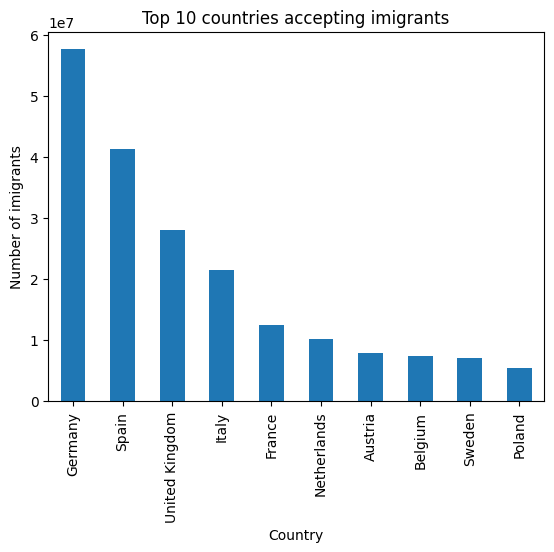

In [123]:
immigrants_by_country = filtered.groupby("geo")["Migrants number"].sum().sort_values(ascending=False)
immigrants_by_country.head(10).plot(kind='bar', title="Top 10 countries accepting imigrants")
plt.xlabel("Country")
plt.ylabel("Number of imigrants")
plt.show()


Najwięcej imigrantów przyjmują:
* NIEMCY
* HISZPANIA
* WIELKA BRYTANIA
* WŁOCHY
* HOLANDIA
* FRANCJA

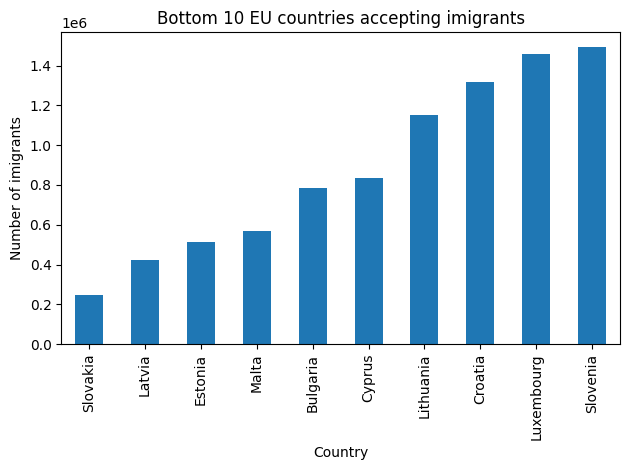

In [124]:
bottom15 = immigrants_by_country.sort_values().head(10)

bottom15.plot(kind='bar', title="Bottom 10 EU countries accepting imigrants")
plt.xlabel("Country")
plt.ylabel("Number of imigrants")
plt.tight_layout()
plt.show()

### Analiza według obywatelstwa (kraj pochodzenia)

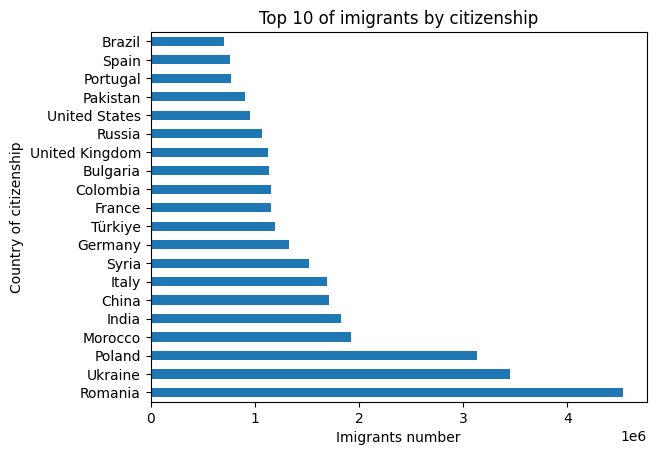

In [125]:
filtered_interest = filtered[~filtered["Country of citizenship"].str.contains("Reporting country|Foreign country|except|EU|Total|Stateless", case=False, na=False)]
top_origins = filtered_interest.groupby("Country of citizenship")["Migrants number"].sum().sort_values(ascending=False)

top_origins.head(20).plot(kind='barh', title="Top 10 of imigrants by citizenship")
plt.xlabel("Imigrants number")
plt.show()


### Macierze migracji: skąd -> dokąd

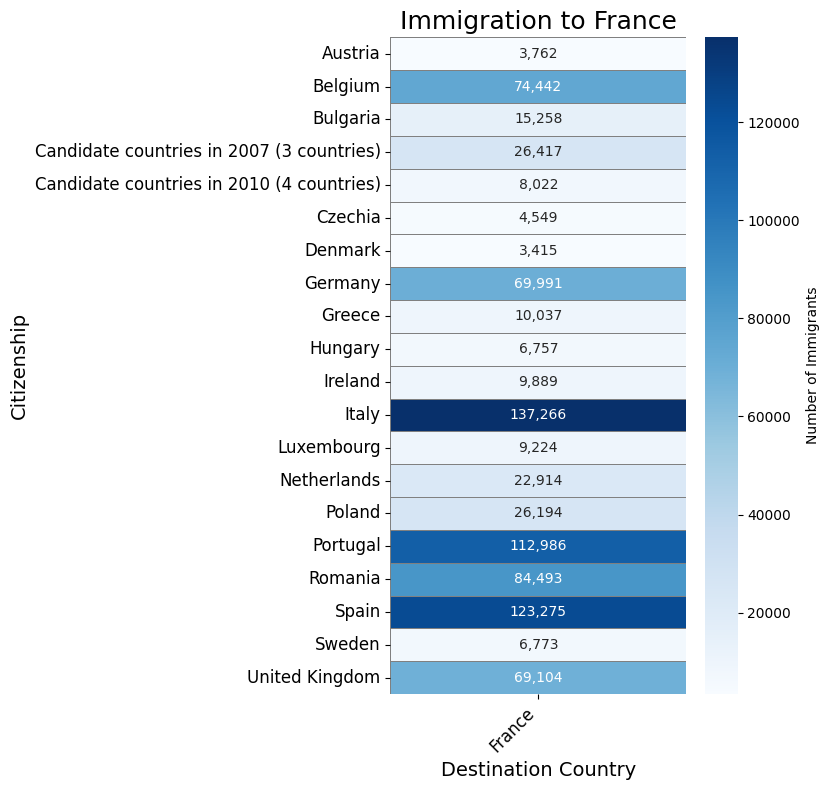

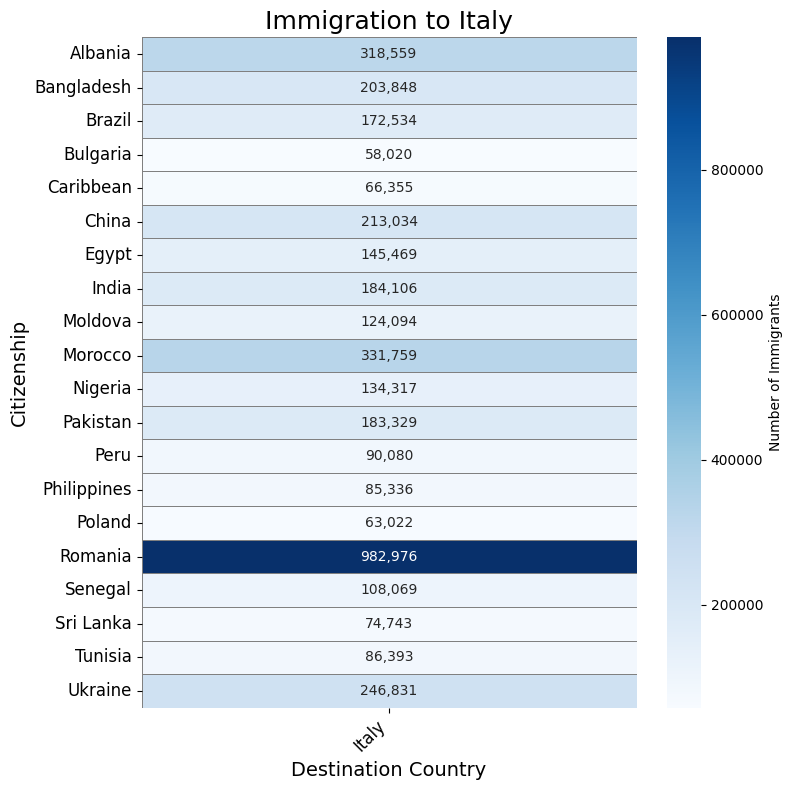

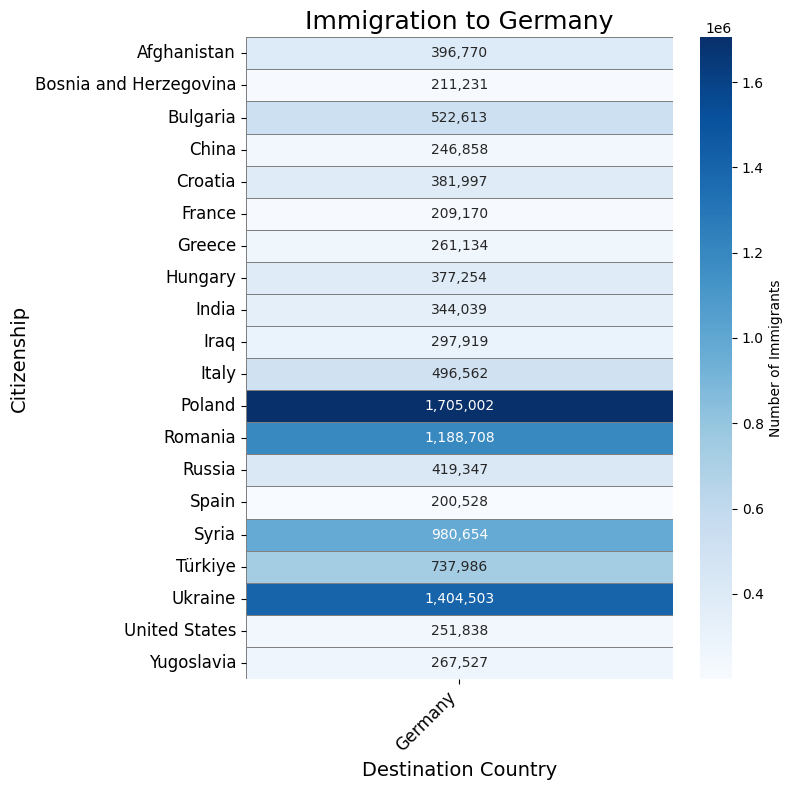

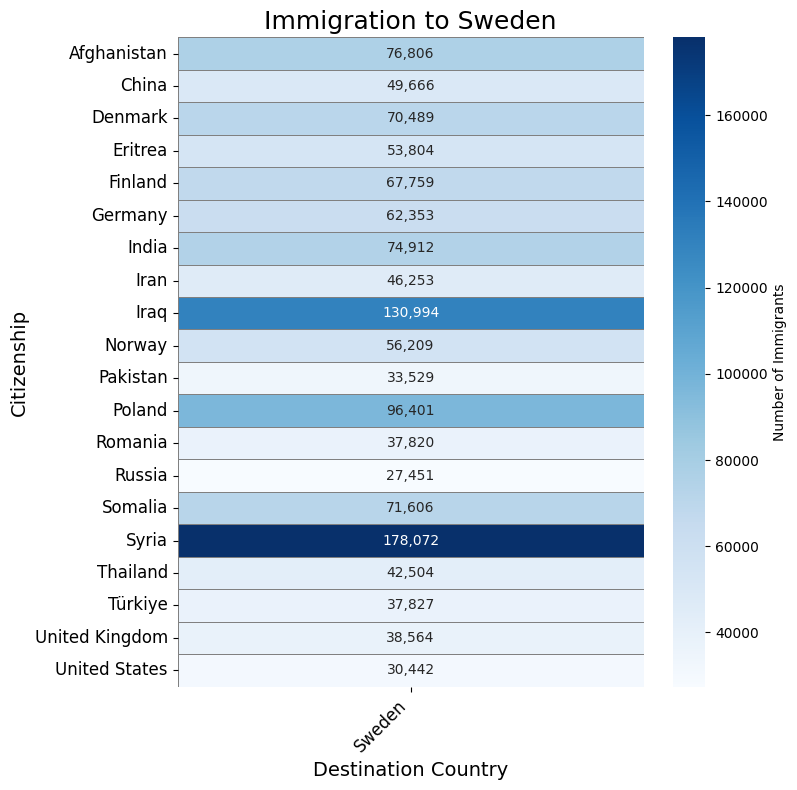

In [126]:

countries_of_interest = ['France', 'Italy', 'Germany', 'Sweden']


filtered_interest = filtered[~filtered["Country of citizenship"].str.contains(
    "Reporting country|Foreign country|except|EU|Total|Stateless", case=False, na=False)]
filtered_interest = filtered_interest[filtered_interest["geo"].isin(countries_of_interest)]


pivot_table = filtered_interest.pivot_table(
    index="Country of citizenship",
    columns="geo",
    values="Migrants number",
    aggfunc="sum"
)


pivot_table = pivot_table.apply(lambda x: x.nlargest(20), axis=0)


for country in countries_of_interest:

    country_data = pivot_table[[country]].fillna(0)
    country_data = country_data[country_data[country] > 0]

  
    plt.figure(figsize=(8, 8))  
    sns.heatmap(
        country_data, 
        cmap="Blues", 
        linewidths=0.7,  
        linecolor="gray", 
        cbar_kws={'label': 'Number of Immigrants'},
        annot=True,  
        fmt=",.0f" 
    )

    plt.title(f"Immigration to {country}", fontsize=18)  
    plt.xlabel("Destination Country", fontsize=14)  
    plt.ylabel("Citizenship", fontsize=14)  
    

    plt.xticks(rotation=45, ha="right", fontsize=12)  
    plt.yticks(fontsize=12)  
    plt.tight_layout() 

    
    plt.show()


Gdzie migrują Polacy?

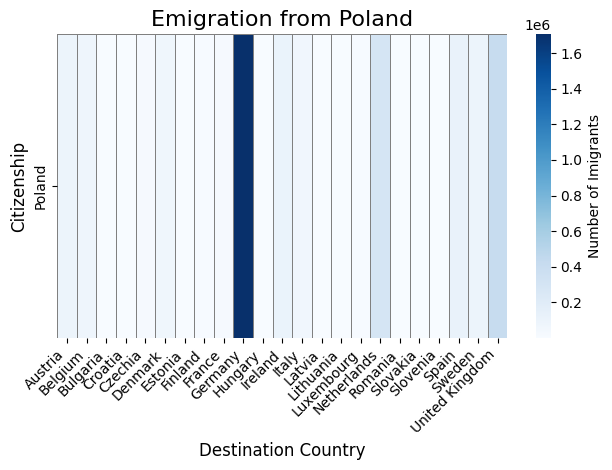

In [127]:
filtered_interest = filtered[filtered["Country of citizenship"] == "Poland"]

pivot_table = filtered_interest.pivot_table(
    index="Country of citizenship",
    columns="geo",
    values="Migrants number",
    aggfunc="sum"
)

sns.heatmap(
    pivot_table, 
    cmap="Blues", 
    linewidths=0.5, 
    linecolor="gray", 
    cbar_kws={'label': 'Number of Imigrants'}
)

plt.title(f"Emigration from Poland", fontsize=16)
plt.xlabel("Destination Country", fontsize=12)
plt.ylabel(f"Citizenship", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

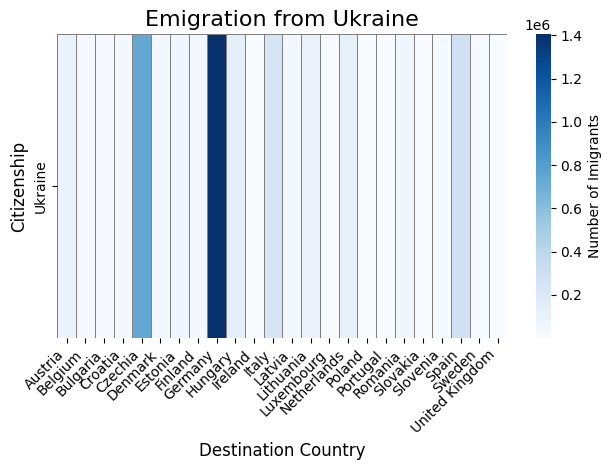

In [128]:
filtered_interest = filtered[filtered["Country of citizenship"] == "Ukraine"]

pivot_table = filtered_interest.pivot_table(
    index="Country of citizenship",
    columns="geo",
    values="Migrants number",
    aggfunc="sum"
)

sns.heatmap(
    pivot_table, 
    cmap="Blues", 
    linewidths=0.5, 
    linecolor="gray", 
    cbar_kws={'label': 'Number of Imigrants'}
)

plt.title(f"Emigration from Ukraine", fontsize=16)
plt.xlabel("Destination Country", fontsize=12)
plt.ylabel(f"Citizenship", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Trendy czasowe w migracji dla wybranych krajów

Dla całego świata

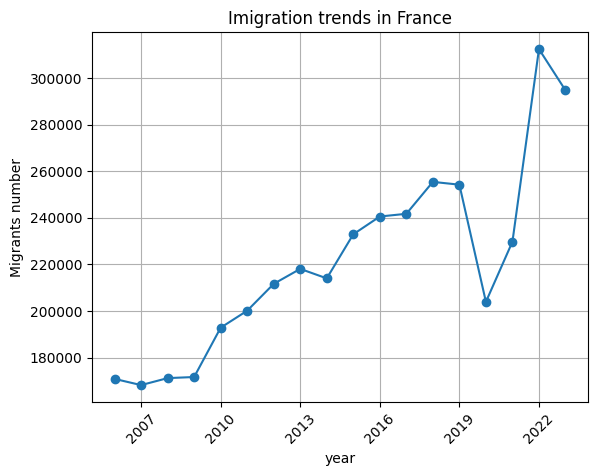

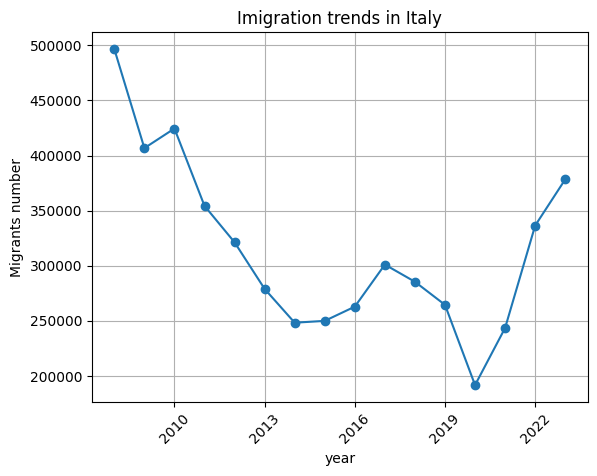

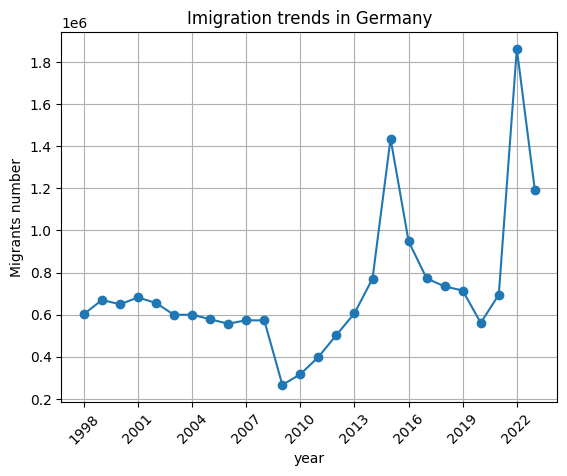

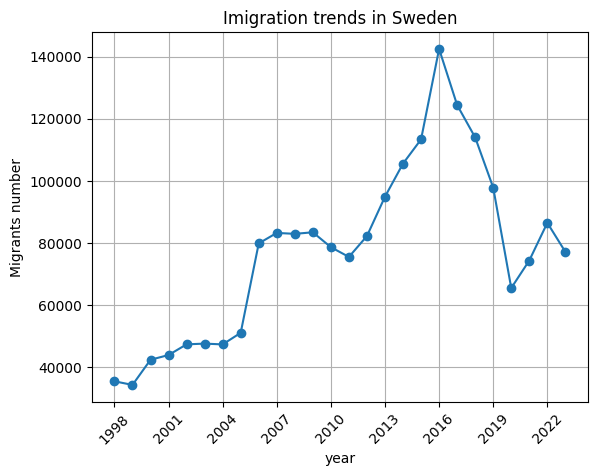

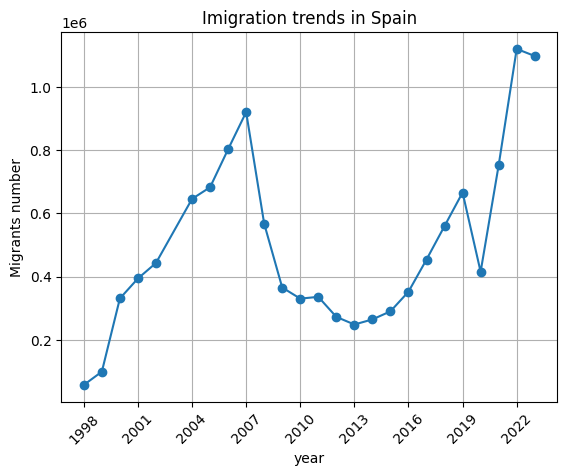

In [129]:
countries_of_interest = ['France', 'Italy', 'Germany', 'Sweden', 'Spain']

filtered_interest = filtered[(filtered["geo"].isin(countries_of_interest)) & (filtered["Country of citizenship"] == "Foreign country and stateless")]

for country in countries_of_interest:

    trend = filtered_interest[filtered_interest["geo"] == country].groupby("year")["Migrants number"].sum()

   
    trend.plot(title=f"Imigration trends in {country}", marker='o')
    plt.ylabel("Migrants number")
    
    
    years = sorted(trend.index.unique())
    ticks_every_3 = [year for year in years if year % 3 == 0]
    plt.xticks(ticks_every_3, rotation=45)
    
  
    plt.grid(True)
    

    plt.show()


/var/folders/gv/3p7t69hn5_1738x9lpr2mqr1zcfrz8/T/ipykernel_15618/249683899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_interest["from_EU"] = filtered_interest["Country of citizenship"].isin(eu_countries)


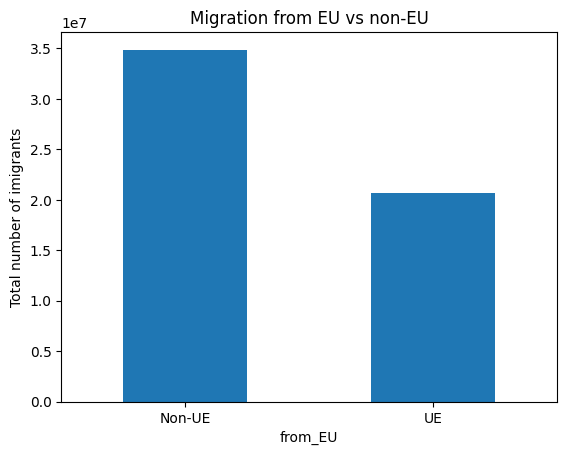

In [130]:
filtered_interest = filtered[~filtered["Country of citizenship"].str.contains("Reporting country|Foreign country|except|EU|Total|Stateless", case=False, na=False)]
filtered_interest["from_EU"] = filtered_interest["Country of citizenship"].isin(eu_countries)

filtered_interest.groupby("from_EU")["Migrants number"].sum().plot(kind='bar', title="Migration from EU vs non-EU")
plt.xticks([0, 1], ['Non-UE', 'UE'], rotation=0)
plt.ylabel("Total number of imigrants")
plt.show()

/var/folders/gv/3p7t69hn5_1738x9lpr2mqr1zcfrz8/T/ipykernel_15618/1351838953.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_interest["from_EU"] = filtered_interest["Country of citizenship"].isin(eu_countries)


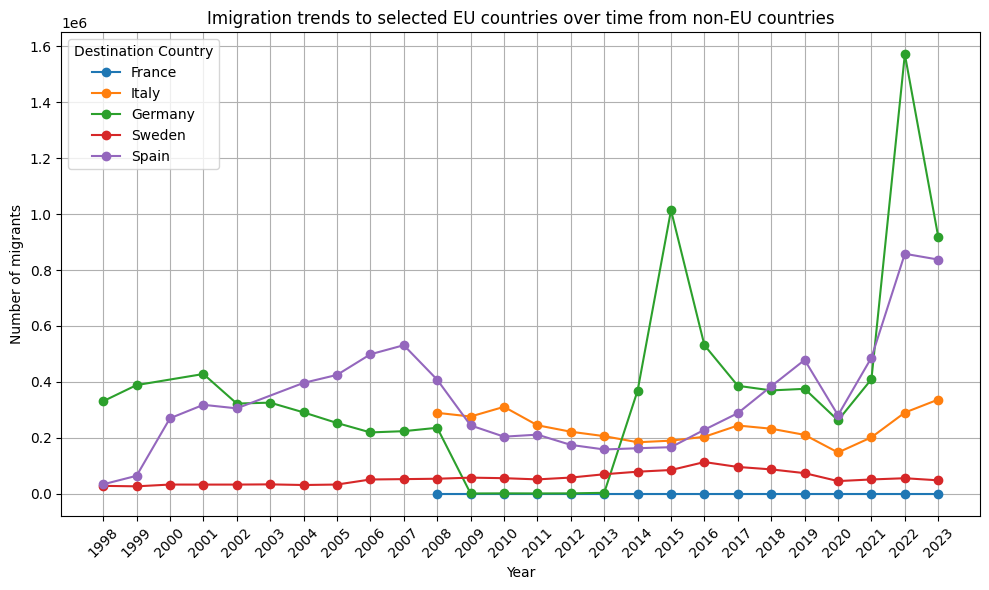

In [131]:
countries_of_interest = ['France', 'Italy', 'Germany', 'Sweden', 'Spain']

filtered_interest = filtered[
    ~filtered["Country of citizenship"].str.contains("Reporting country|Foreign country|except|EU|Total|candidate", case=False, na=False)
]

filtered_interest["from_EU"] = filtered_interest["Country of citizenship"].isin(eu_countries)

filtered_interest = filtered_interest[(filtered_interest["geo"].isin(countries_of_interest)) & ~(filtered_interest["from_EU"])]

plt.figure(figsize=(10, 6))

for country in countries_of_interest:
    trend = (
        filtered_interest[filtered_interest["geo"] == country]
        .groupby("year")["Migrants number"]
        .sum()
    )
    plt.plot(trend.index, trend.values, marker='o', label=country)


plt.title("Imigration trends to selected EU countries over time from non-EU countries")
plt.xlabel("Year")
plt.ylabel("Number of migrants")
plt.xticks(sorted(filtered_interest["year"].unique()), rotation=45)
plt.grid(True)
plt.legend(title="Destination Country")
plt.tight_layout()


plt.show()


/var/folders/gv/3p7t69hn5_1738x9lpr2mqr1zcfrz8/T/ipykernel_15618/2993350355.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_interest["from_EU"] = filtered_interest["Country of citizenship"].isin(eu_countries)


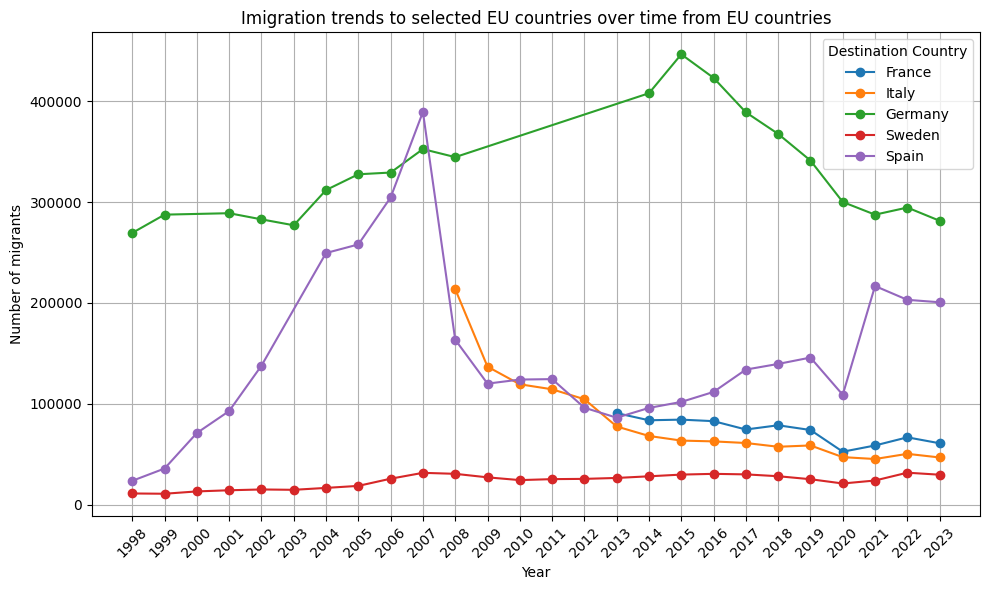

In [132]:
countries_of_interest = ['France', 'Italy', 'Germany', 'Sweden', 'Spain']


filtered_interest = filtered[~filtered["Country of citizenship"].str.contains("Reporting country|Foreign country|except|EU|Total|Stateless", case=False, na=False)]

filtered_interest["from_EU"] = filtered_interest["Country of citizenship"].isin(eu_countries)

filtered_interest = filtered_interest[(filtered_interest["geo"].isin(countries_of_interest)) & (filtered_interest["from_EU"])]

plt.figure(figsize=(10, 6))

for country in countries_of_interest:
    trend = (
        filtered_interest[filtered_interest["geo"] == country]
        .groupby("year")["Migrants number"]
        .sum()
    )
    plt.plot(trend.index, trend.values, marker='o', label=country)


plt.title("Imigration trends to selected EU countries over time from EU countries")
plt.xlabel("Year")
plt.ylabel("Number of migrants")
plt.xticks(sorted(filtered_interest["year"].unique()), rotation=45)
plt.grid(True)
plt.legend(title="Destination Country")
plt.tight_layout()


plt.show()



Analiza migracji w czasie dla Polski

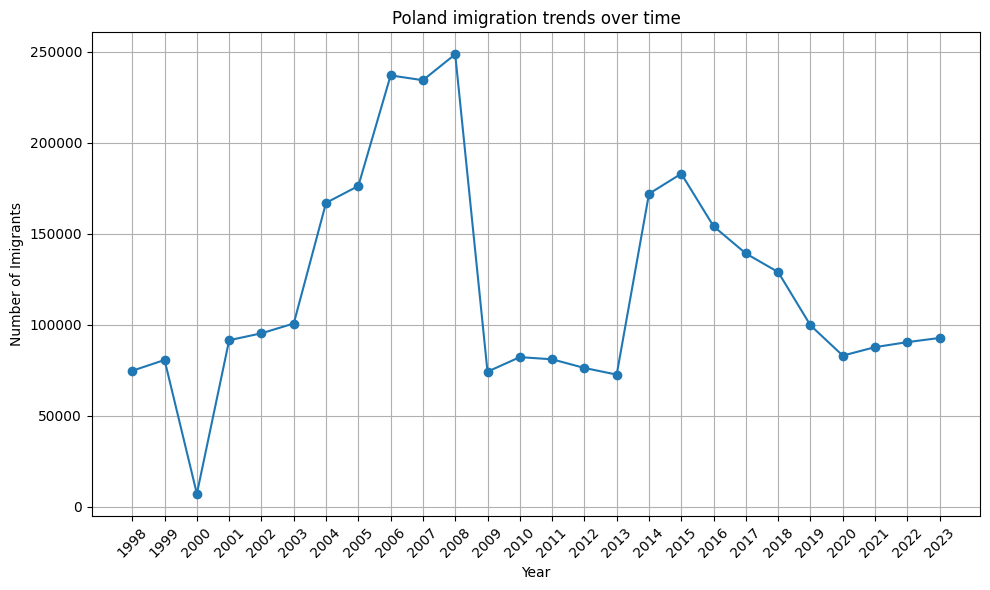

In [133]:
filtered_interest = filtered[filtered["Country of citizenship"] == "Poland"]

plt.figure(figsize=(10, 6))


trend = (
    filtered_interest
    .groupby("year")["Migrants number"]
    .sum()
)
plt.plot(trend.index, trend.values, marker='o', label=country)

plt.title("Poland imigration trends over time")
plt.xlabel("Year")
plt.ylabel("Number of Imigrants")
plt.xticks(sorted(filtered_interest["year"].unique()), rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

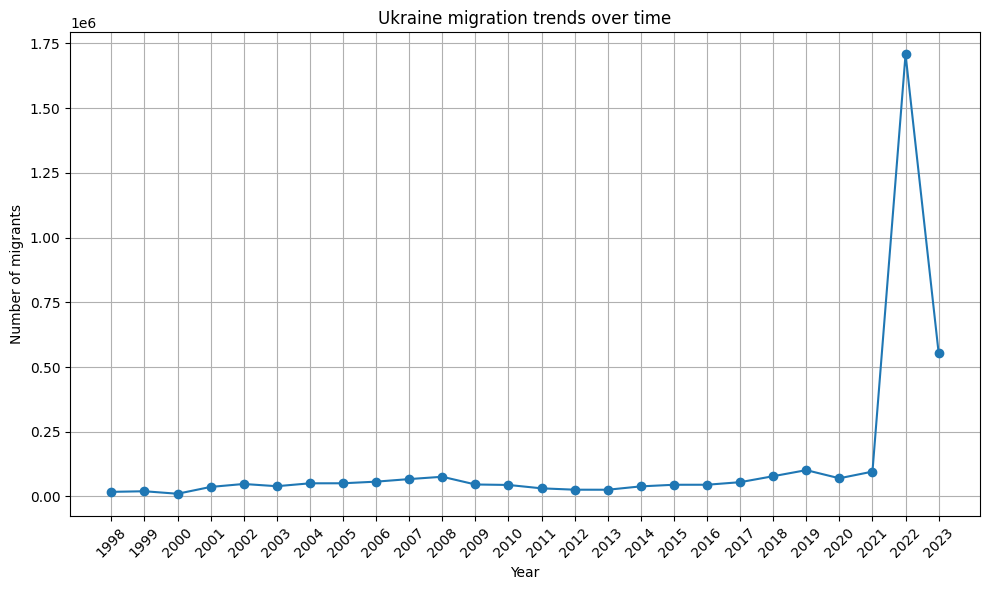

In [134]:
filtered_interest = filtered[filtered["Country of citizenship"] == "Ukraine"]

plt.figure(figsize=(10, 6))


trend = (
    filtered_interest
    .groupby("year")["Migrants number"]
    .sum()
)
plt.plot(trend.index, trend.values, marker='o', label=country)

plt.title("Ukraine migration trends over time")
plt.xlabel("Year")
plt.ylabel("Number of migrants")
plt.xticks(sorted(filtered_interest["year"].unique()), rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# All valid permits by reason, length of validity and citzenship on 31 December of each year

Zawiera szczegółowe informacje na temat ważnych pozwoleń na pobyt wydanych cudzoziemcom w krajach UE i EFTA na koniec każdego roku. Zbiór nie bierze pod uwagę uchodźców wojennych.

In [135]:
all_valid_permits = pd.read_csv('../processed_data/migrants_all_valid_permits.csv')

all_valid_permits = all_valid_permits[~all_valid_permits["geo"].str.contains("European", case=False, na=False)]


In [136]:
all_valid_permits.head()

,Country of citizenship,geo,Migrants number,year,Population,Migrants number per 100k inhabitants
0,Andorra,Austria,1.0,2016,8700471,0.01
1,Andorra,Austria,2.0,2017,8772865,0.02
2,Andorra,Austria,2.0,2018,8822267,0.02
3,Andorra,Austria,2.0,2019,8858775,0.02
4,Andorra,Austria,2.0,2020,8901064,0.02


### Analiza wydanych pozwoleń w poszczególnych krajach

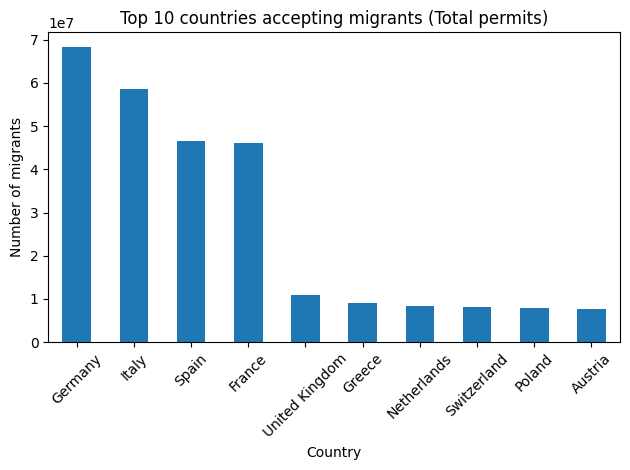

In [137]:
total_permits = all_valid_permits[all_valid_permits["Country of citizenship"] == "Total"]

top10 = total_permits.groupby("geo")["Migrants number"].sum().sort_values(ascending=False).head(10)

top10.plot(kind='bar', title="Top 10 countries accepting migrants (Total permits)")
plt.xlabel("Country")
plt.ylabel("Number of migrants")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


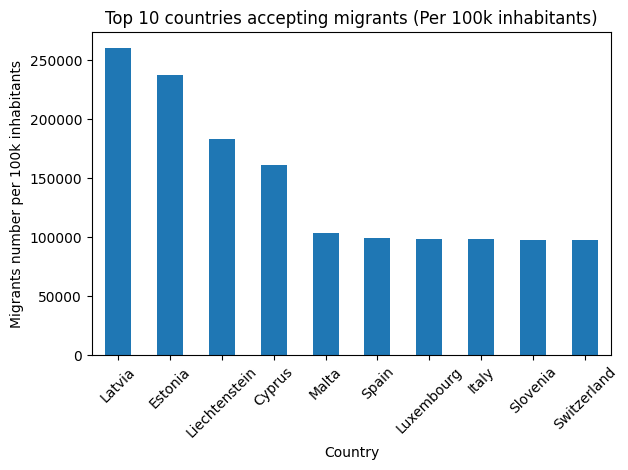

In [138]:
total_permits = all_valid_permits[all_valid_permits["Country of citizenship"] == "Total"]

top10 = total_permits.groupby("geo")["Migrants number per 100k inhabitants"].sum().sort_values(ascending=False).head(10)

top10.plot(kind='bar', title="Top 10 countries accepting migrants (Per 100k inhabitants)")
plt.xlabel("Country")
plt.ylabel("Migrants number per 100k inhabitants")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


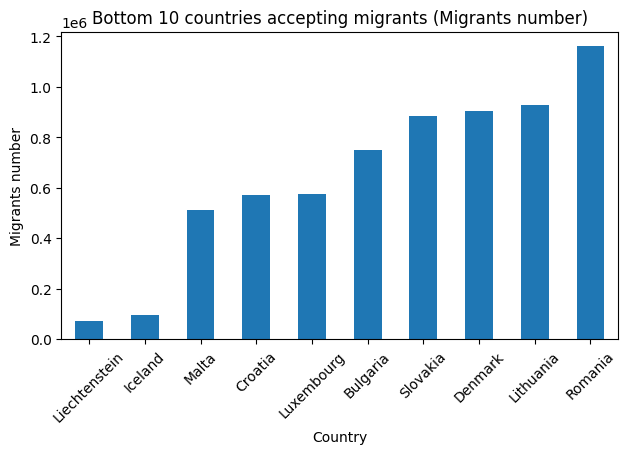

In [139]:
total_permits = all_valid_permits[all_valid_permits["Country of citizenship"] == "Total"]

bottom10 = total_permits.groupby("geo")["Migrants number"].sum().sort_values(ascending=True).head(10)

bottom10.plot(kind='bar', title="Bottom 10 countries accepting migrants (Migrants number)")
plt.xlabel("Country")
plt.ylabel("Migrants number")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


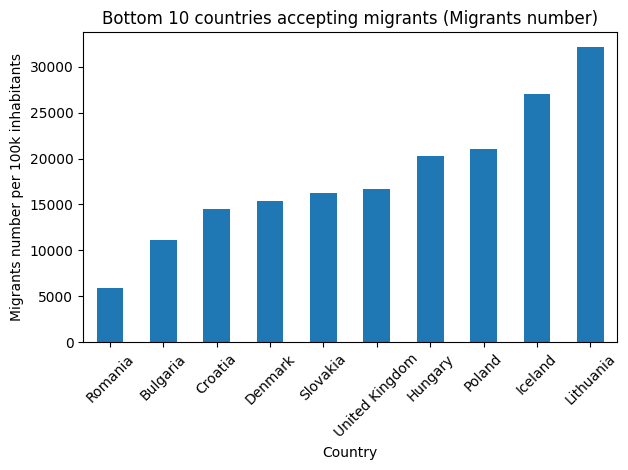

In [140]:
total_permits = all_valid_permits[all_valid_permits["Country of citizenship"] == "Total"]

bottom10 = total_permits.groupby("geo")["Migrants number per 100k inhabitants"].sum().sort_values(ascending=True).head(10)

bottom10.plot(kind='bar', title="Bottom 10 countries accepting migrants (Migrants number)")
plt.xlabel("Country")
plt.ylabel("Migrants number per 100k inhabitants")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Analiza wydanych pozwoleń (rozkład w czasie)

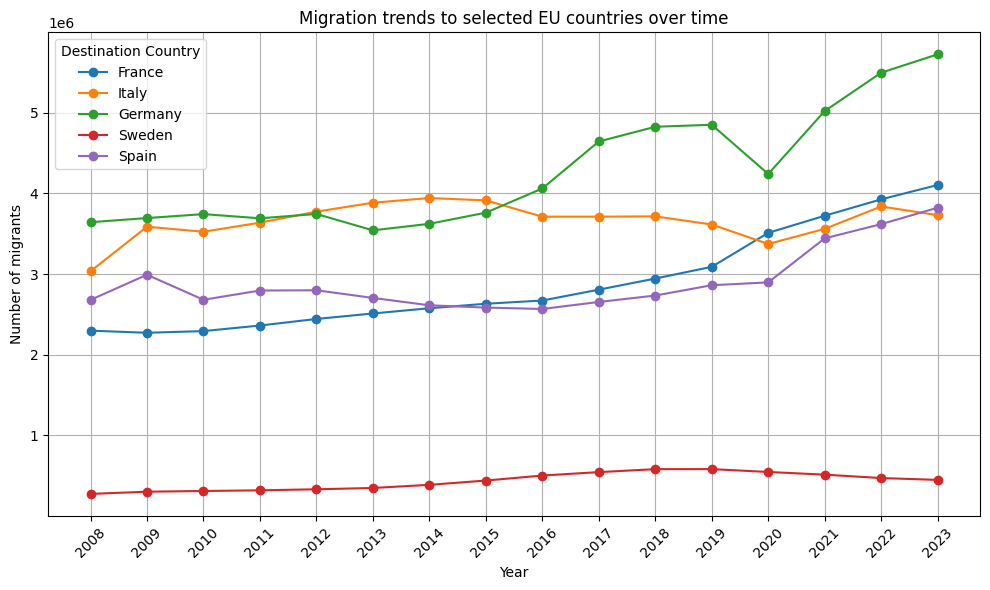

In [141]:
countries_of_interest = ['France', 'Italy', 'Germany', 'Sweden', 'Spain']

filtered_interest = all_valid_permits[
    (all_valid_permits["geo"].isin(countries_of_interest)) &
    (all_valid_permits["Country of citizenship"] == "Total")
]

plt.figure(figsize=(10, 6))

for country in countries_of_interest:
    trend = filtered_interest[filtered_interest["geo"] == country]
    plt.plot(trend["year"], trend["Migrants number"], marker='o', label=country)

plt.title("Migration trends to selected EU countries over time")
plt.xlabel("Year")
plt.ylabel("Number of migrants")
plt.xticks(sorted(filtered_interest["year"].unique()), rotation=45)
plt.grid(True)
plt.legend(title="Destination Country")
plt.tight_layout()
plt.show()




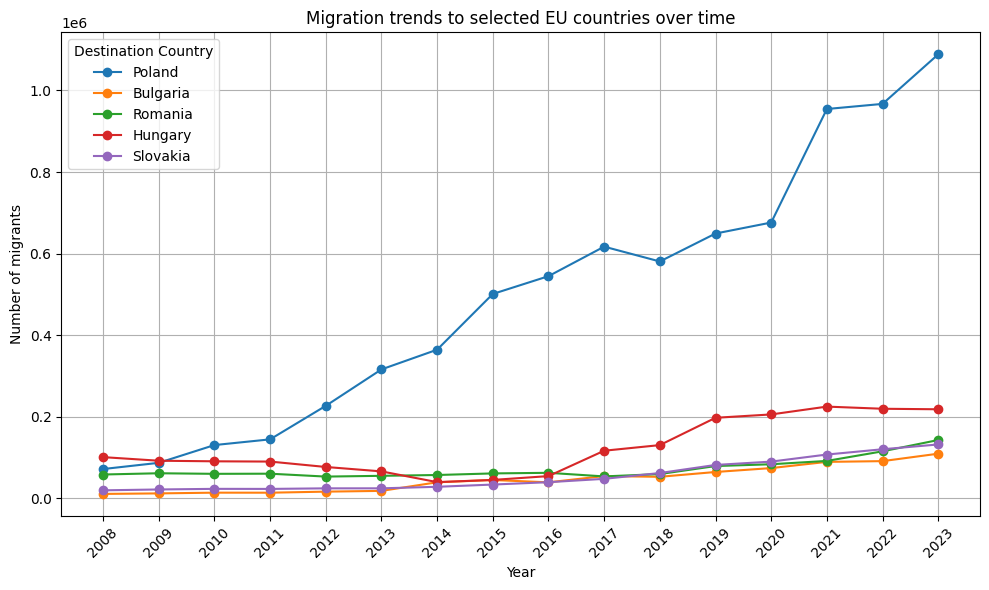

In [142]:
countries_of_interest = ['Poland', 'Bulgaria', 'Romania', 'Hungary', 'Slovakia']

filtered_interest = all_valid_permits[
    (all_valid_permits["geo"].isin(countries_of_interest)) &
    (all_valid_permits["Country of citizenship"] == "Total")
]

plt.figure(figsize=(10, 6))

for country in countries_of_interest:
    trend = filtered_interest[filtered_interest["geo"] == country]
    plt.plot(trend["year"], trend["Migrants number"], marker='o', label=country)

plt.title("Migration trends to selected EU countries over time")
plt.xlabel("Year")
plt.ylabel("Number of migrants")
plt.xticks(sorted(filtered_interest["year"].unique()), rotation=45)
plt.grid(True)
plt.legend(title="Destination Country")
plt.tight_layout()
plt.show()


In [143]:
eu_countries = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia',
    'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania',
    'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
    'Spain', 'Sweden', 'United Kingdom'
]  # plus United Kingdom!!

In [144]:
countries_of_interest = ['France', 'Italy', 'Germany', 'Sweden', 'Spain']
filtered_interest = all_valid_permits[all_valid_permits["geo"].isin(countries_of_interest)]
non_eu_filtered = filtered_interest[~filtered_interest["Country of citizenship"].isin(eu_countries)]

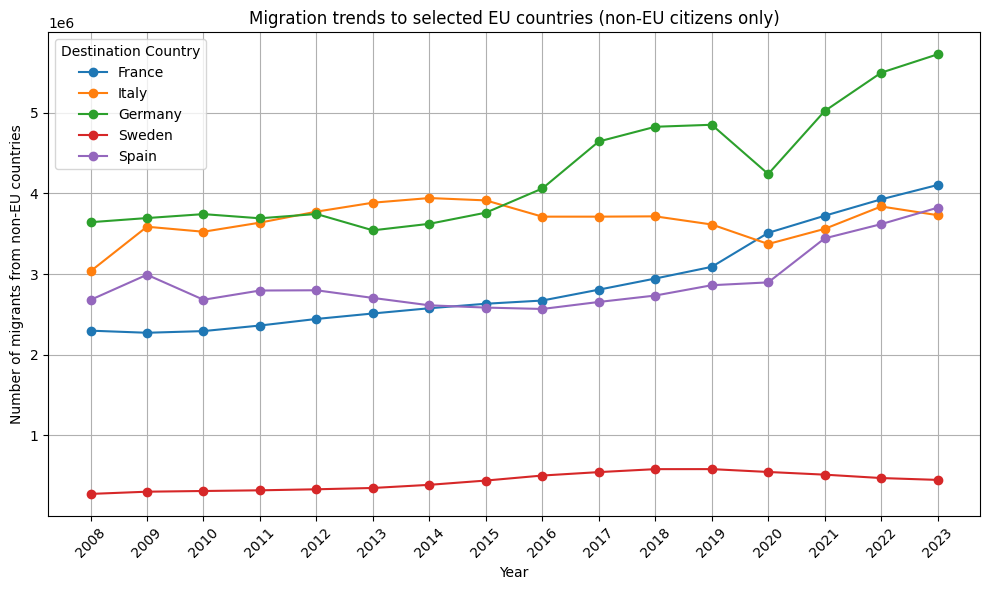

In [145]:
plt.figure(figsize=(10, 6))

for country in countries_of_interest:
    trend = non_eu_filtered[
        (non_eu_filtered["geo"] == country) & 
        (non_eu_filtered["Country of citizenship"] == "Total")
    ]
    trend = trend.sort_values("year")
    plt.plot(trend["year"], trend["Migrants number"], marker='o', label=country)

plt.title("Migration trends to selected EU countries (non-EU citizens only)")
plt.xlabel("Year")
plt.ylabel("Number of migrants from non-EU countries")
plt.xticks(sorted(non_eu_filtered["year"].unique()), rotation=45)
plt.grid(True)
plt.legend(title="Destination Country")
plt.tight_layout()
plt.show()

### Sprawdzenie trendów dla Ukrainy

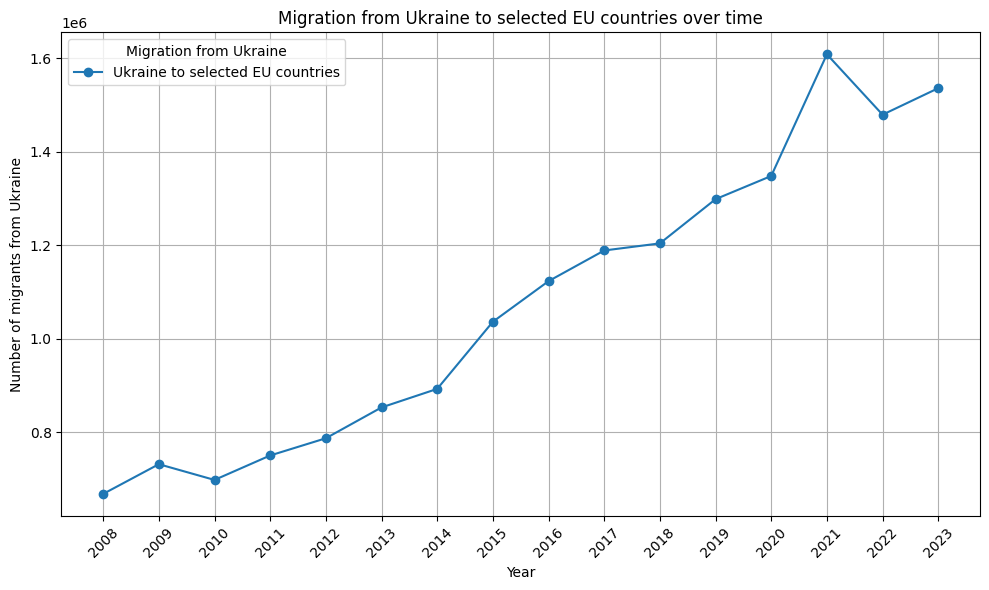

In [146]:
ukraine_migration = all_valid_permits[
    (all_valid_permits["Country of citizenship"] == "Ukraine")
]

ukraine_trends = ukraine_migration.groupby("year")["Migrants number"].sum()

plt.figure(figsize=(10, 6))
plt.plot(ukraine_trends.index, ukraine_trends.values, marker='o', label="Ukraine to selected EU countries")

plt.title("Migration from Ukraine to selected EU countries over time")
plt.xlabel("Year")
plt.ylabel("Number of migrants from Ukraine")
plt.xticks(sorted(ukraine_trends.index), rotation=45)
plt.grid(True)
plt.legend(title="Migration from Ukraine")
plt.tight_layout()
plt.show()


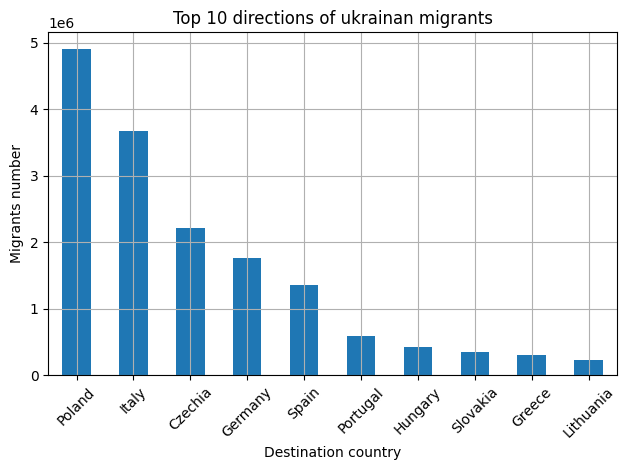

In [147]:
top_ukrain_dest = (
    ukraine_migration.groupby("geo")["Migrants number"]
    .sum()
    .sort_values(ascending=False)
)

top_ukrain_dest.head(10).plot(kind='bar', title="Top 10 directions of ukrainan migrants")
plt.xlabel("Destination country")
plt.ylabel("Migrants number")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Analiza kierunków,z których pochodzą migranci któym wydano zgody na pobyt

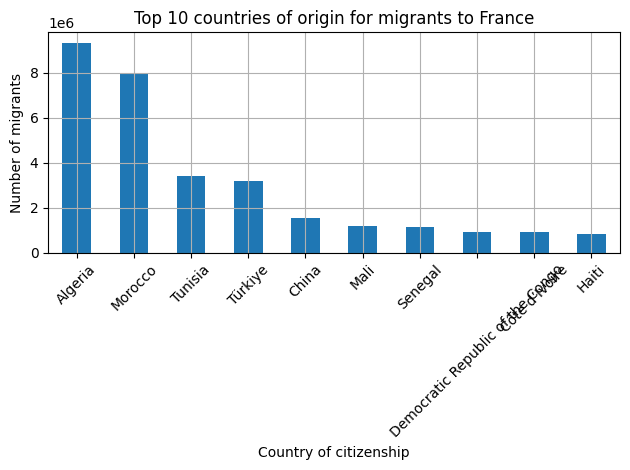

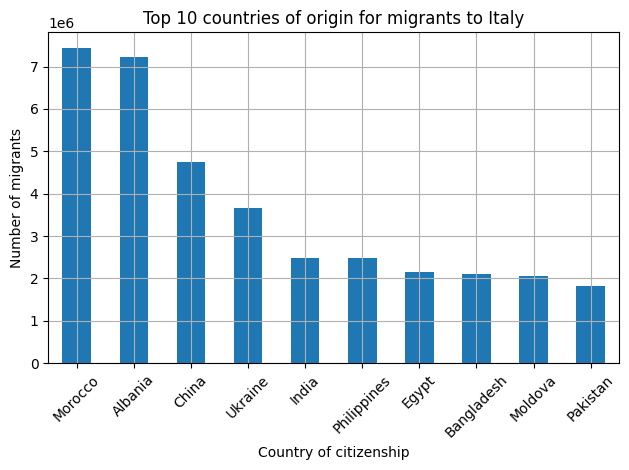

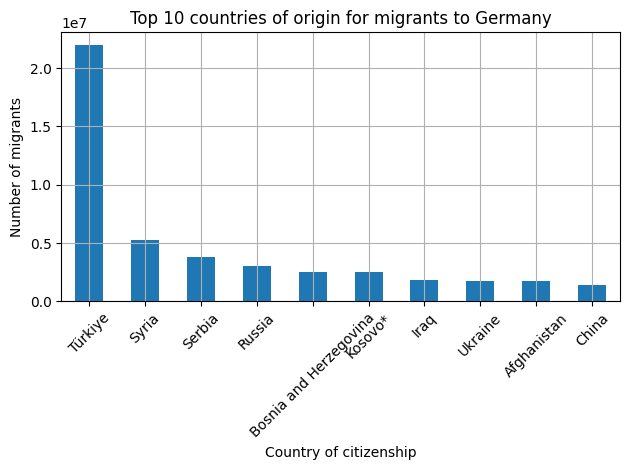

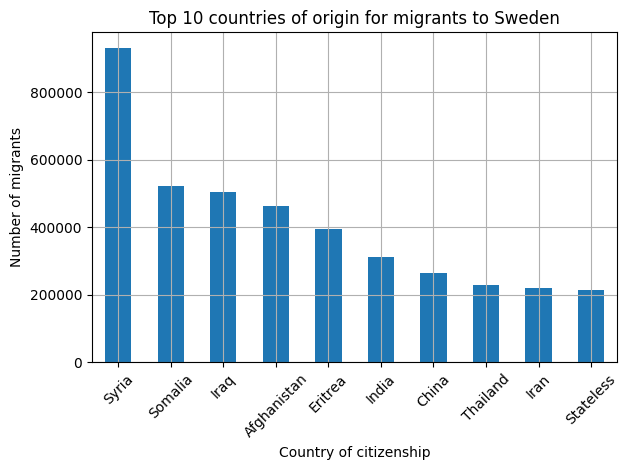

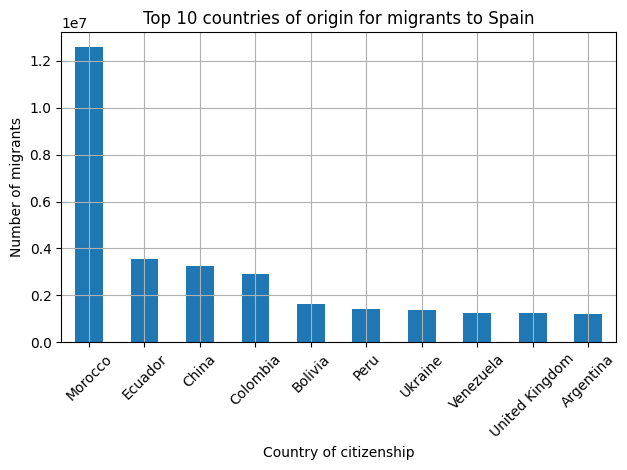

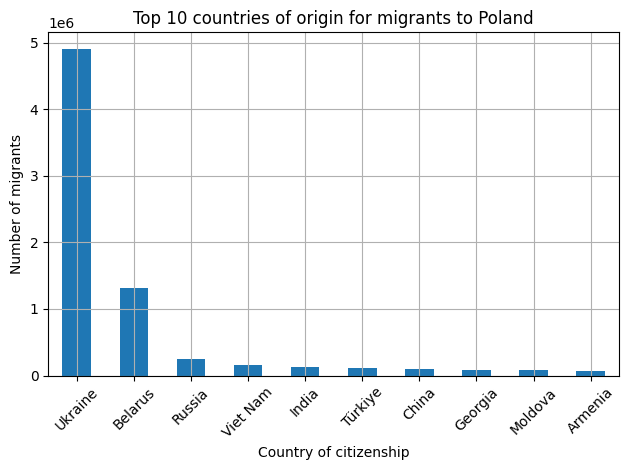

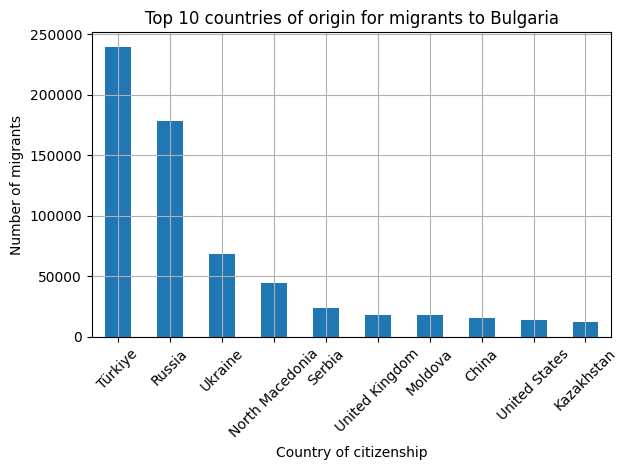

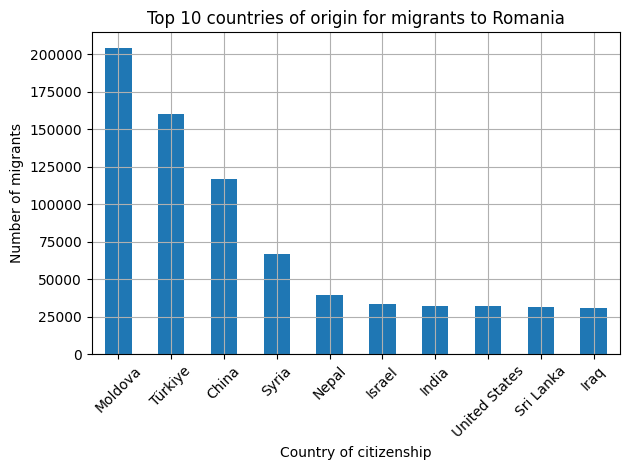

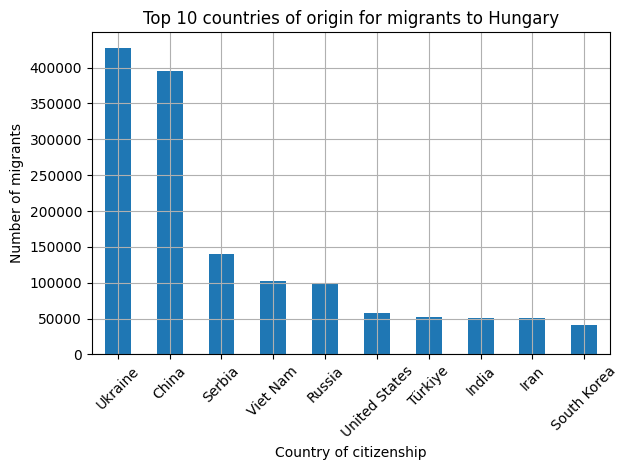

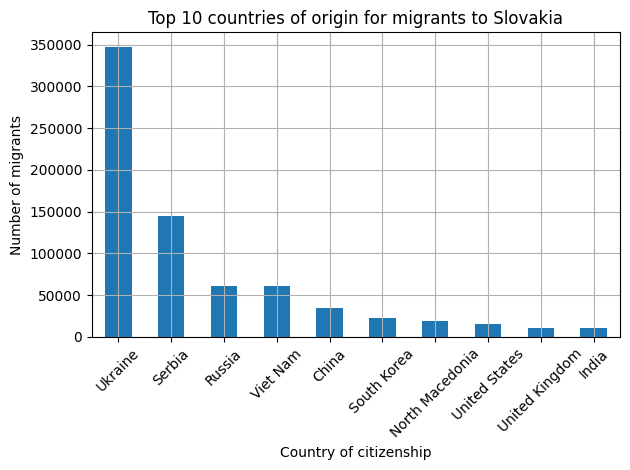

In [148]:
countries_of_interest = ['France', 'Italy', 'Germany', 'Sweden', 'Spain', 'Poland', 'Bulgaria', 'Romania', 'Hungary', 'Slovakia']


filtered = all_valid_permits[all_valid_permits["Country of citizenship"] != "Total"]

for country in countries_of_interest:

    country_data = filtered[filtered["geo"] == country]

    top_countries = (

        country_data.groupby("Country of citizenship")["Migrants number"]
        .sum()
        .sort_values(ascending=False)
        .head(10)  
    )


    top_countries.plot(kind='bar', title=f"Top 10 countries of origin for migrants to {country}")
    plt.xlabel("Country of citizenship")
    plt.ylabel("Number of migrants")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


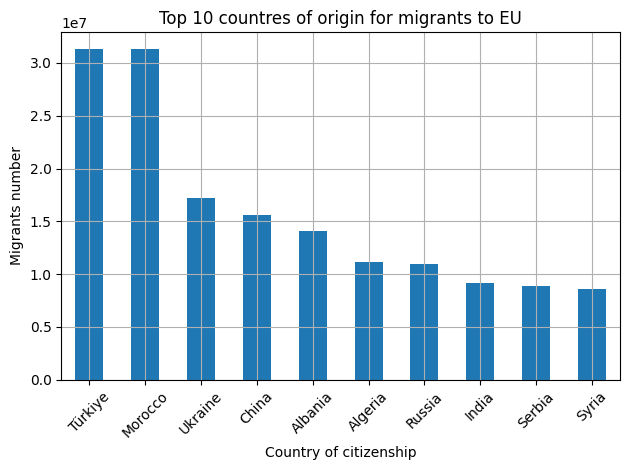

In [149]:
filtered = all_valid_permits[all_valid_permits["Country of citizenship"] != "Total"]

top_origin_countries = (
    filtered.groupby("Country of citizenship")["Migrants number"]
    .sum()
    .sort_values(ascending=False)
)

top_origin_countries.head(10).plot(kind='bar', title="Top 10 countres of origin for migrants to EU")
plt.xlabel("Country of citizenship")
plt.ylabel("Migrants number")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Beneficiaries of temporary protection at the end of the month - Ukraine analysis

In [150]:
ukraine_temp_prot = pd.read_csv('../processed_data/ukraine_temporary_protection.csv')
pd.to_datetime(ukraine_temp_prot['month'], format='%Y-%m')

0      2022-07-01
1      2022-08-01
2      2022-09-01
3      2022-10-01
4      2022-11-01
          ...    
1126   2024-11-01
1127   2024-12-01
1128   2025-01-01
1129   2025-02-01
1130   2025-03-01
Name: month, Length: 1131, dtype: datetime64[ns]

### Analiza kierunków

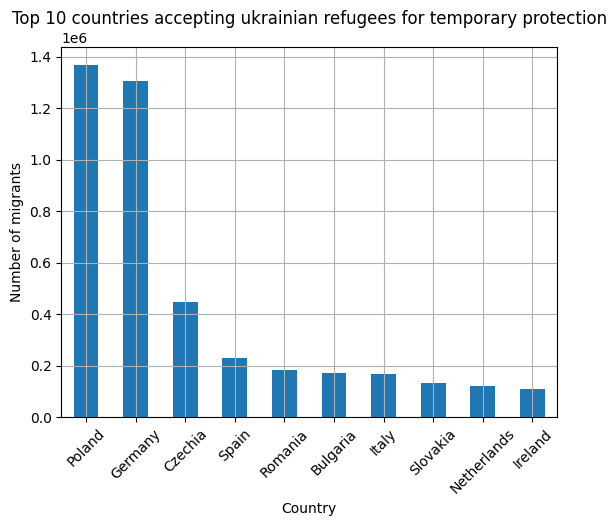

In [151]:
country_df = ukraine_temp_prot.groupby("geo")["OBS_VALUE"].max().sort_values(ascending=False)
country_df.head(10).plot(kind='bar', title="Top 10 countries accepting ukrainian refugees for temporary protection")
plt.xlabel("Country")
plt.ylabel("Number of migrants")
plt.xticks(rotation=45)
plt.grid(True)

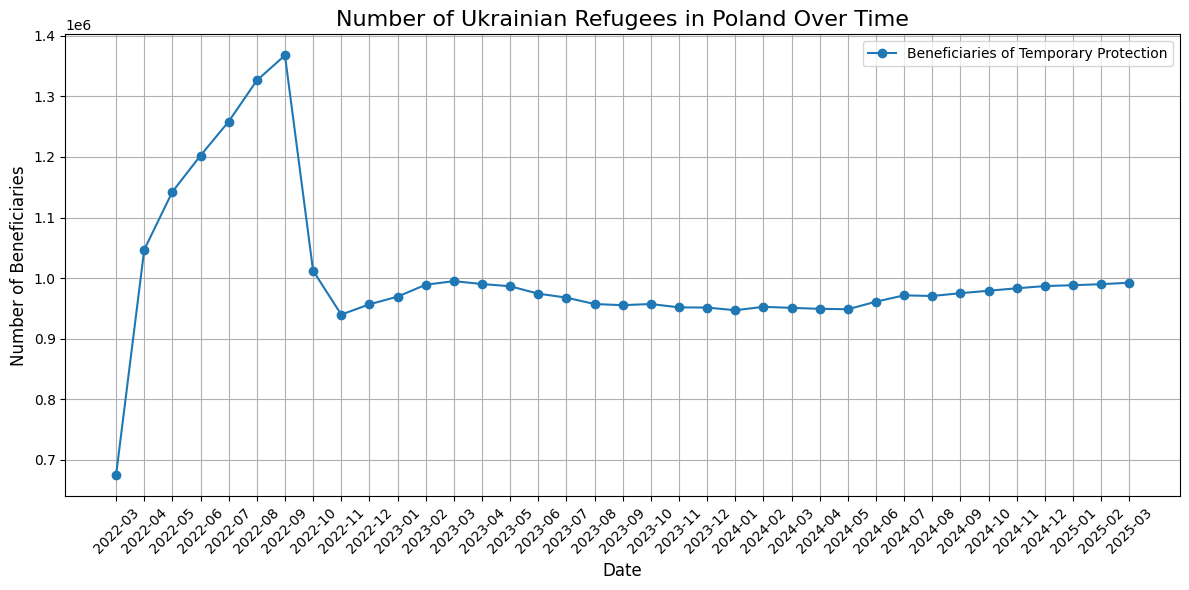

In [152]:
poland_data = ukraine_temp_prot[ukraine_temp_prot['geo'] == 'Poland']

poland_data = poland_data.sort_values('month')


plt.figure(figsize=(12, 6))

plt.plot(poland_data['month'], poland_data['OBS_VALUE'], marker='o', linestyle='-', label='Beneficiaries of Temporary Protection')

plt.title("Number of Ukrainian Refugees in Poland Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Beneficiaries", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



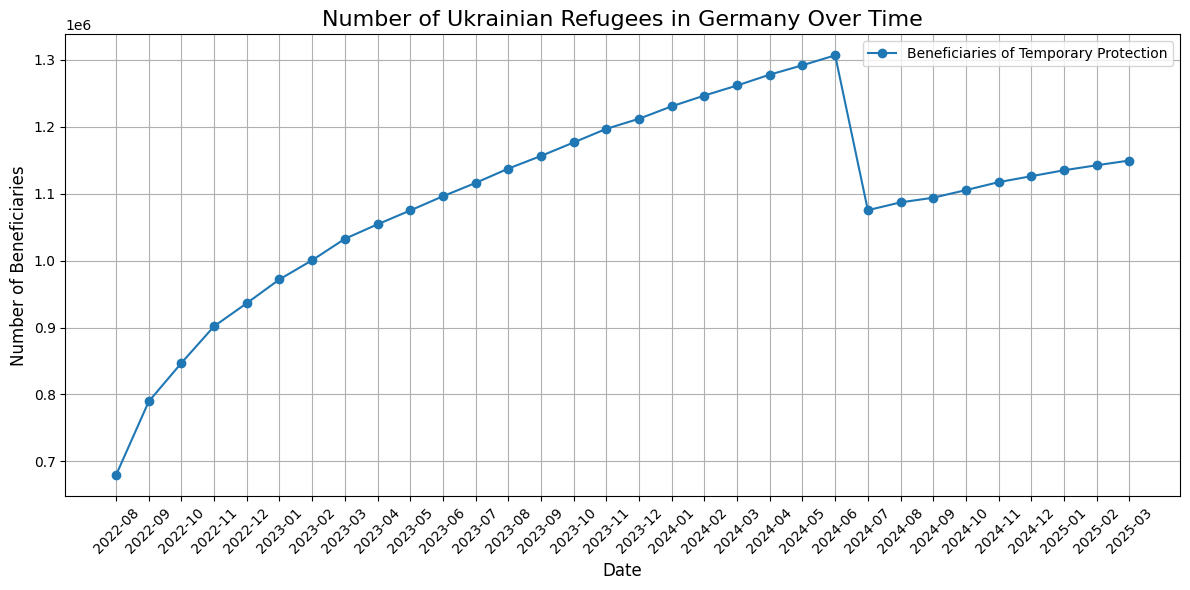

In [153]:
germany_data = ukraine_temp_prot[ukraine_temp_prot['geo'] == 'Germany']

germany_data = germany_data.sort_values('month')


plt.figure(figsize=(12, 6))

plt.plot(germany_data['month'], germany_data['OBS_VALUE'], marker='o', linestyle='-', label='Beneficiaries of Temporary Protection')

plt.title("Number of Ukrainian Refugees in Germany Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Beneficiaries", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()